In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
import networkx as nx
import networkx.algorithms.community as nx_comm
import random
import warnings

warnings.filterwarnings('ignore')

random.seed(1337)

In [8]:
### Preprocess Data

spotify_df = pd.read_csv(f"spotify_songs.csv")

# Remove duplicates
spotify_df = spotify_df.drop_duplicates('track_id').reset_index(drop = True)

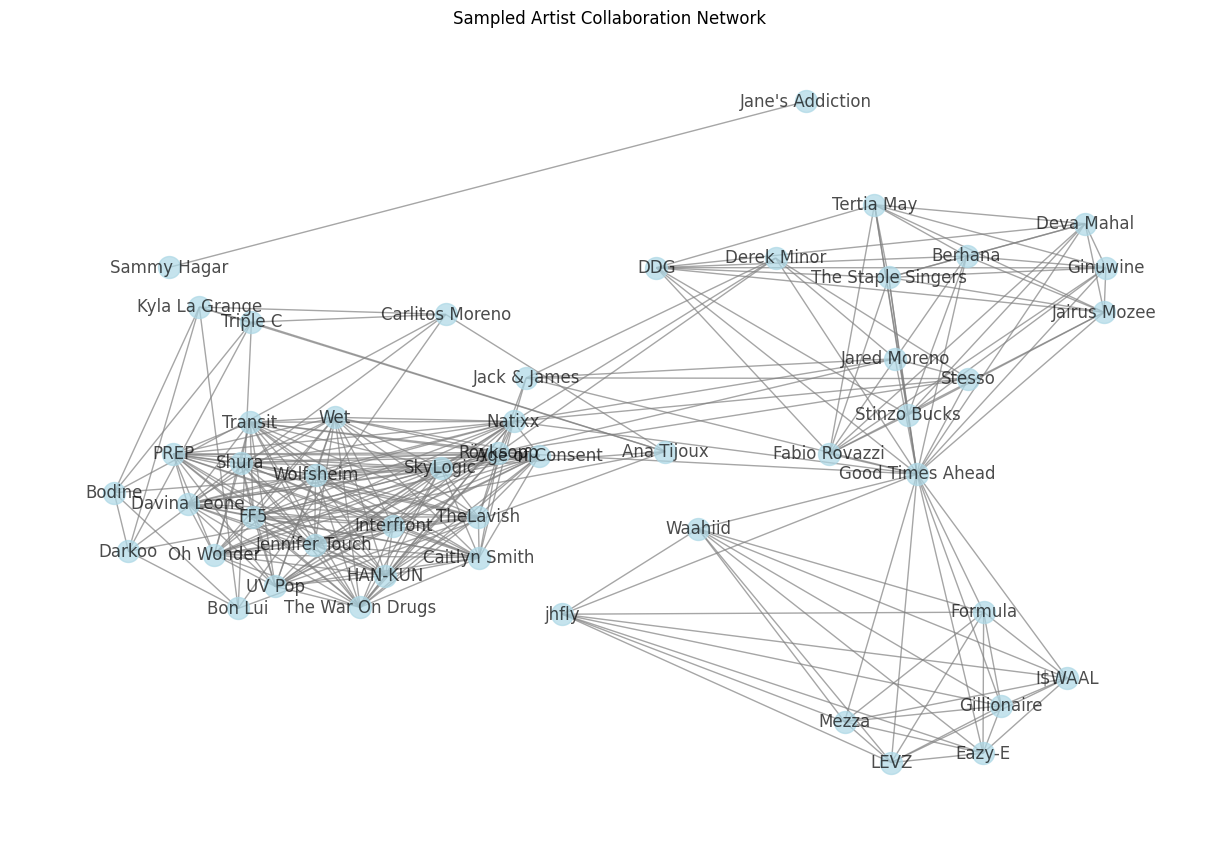

In [9]:
### Artist Collaboration Network
# Create a network where nodes are artists and edges connect artists who appear in the same genre

# Get artist-genre relationships
artist_genre = spotify_df.groupby('track_artist')['playlist_genre'].apply(list).reset_index()

# Create graph
G_artists = nx.Graph()

# Add nodes (artists)
for artist in spotify_df['track_artist'].unique():
    G_artists.add_node(artist)

genre_to_artists = defaultdict(set)
for _, row in artist_genre.iterrows():
    artist = row['track_artist']
    genres = row['playlist_genre']
    for genre in genres:
        genre_to_artists[genre].add(artist)

# For each genre, connect all pairs of artists
artist_connections = defaultdict(int)
for genre, artists in genre_to_artists.items():

    for artist1, artist2 in combinations(artists, 2):
        pair = tuple(sorted([artist1, artist2]))
        artist_connections[pair] += 1

# Add edges to graph
for (artist1, artist2), weight in artist_connections.items():
    G_artists.add_edge(artist1, artist2, weight = weight)

# Plot network
largest_component = max(nx.connected_components(G_artists), key = len)
subgraph = G_artists.subgraph(list(largest_component)[:50])  # Take first 50 nodes

plt.figure(figsize = (12, 8))
pos = nx.spring_layout(subgraph, k = 1, iterations = 50) # Using spring layout 
nx.draw(subgraph, pos, node_size = 250, node_color = 'lightblue', 
        edge_color = 'gray', alpha = 0.7, with_labels = True)
plt.title('Sampled Artist Collaboration Network')
plt.show()

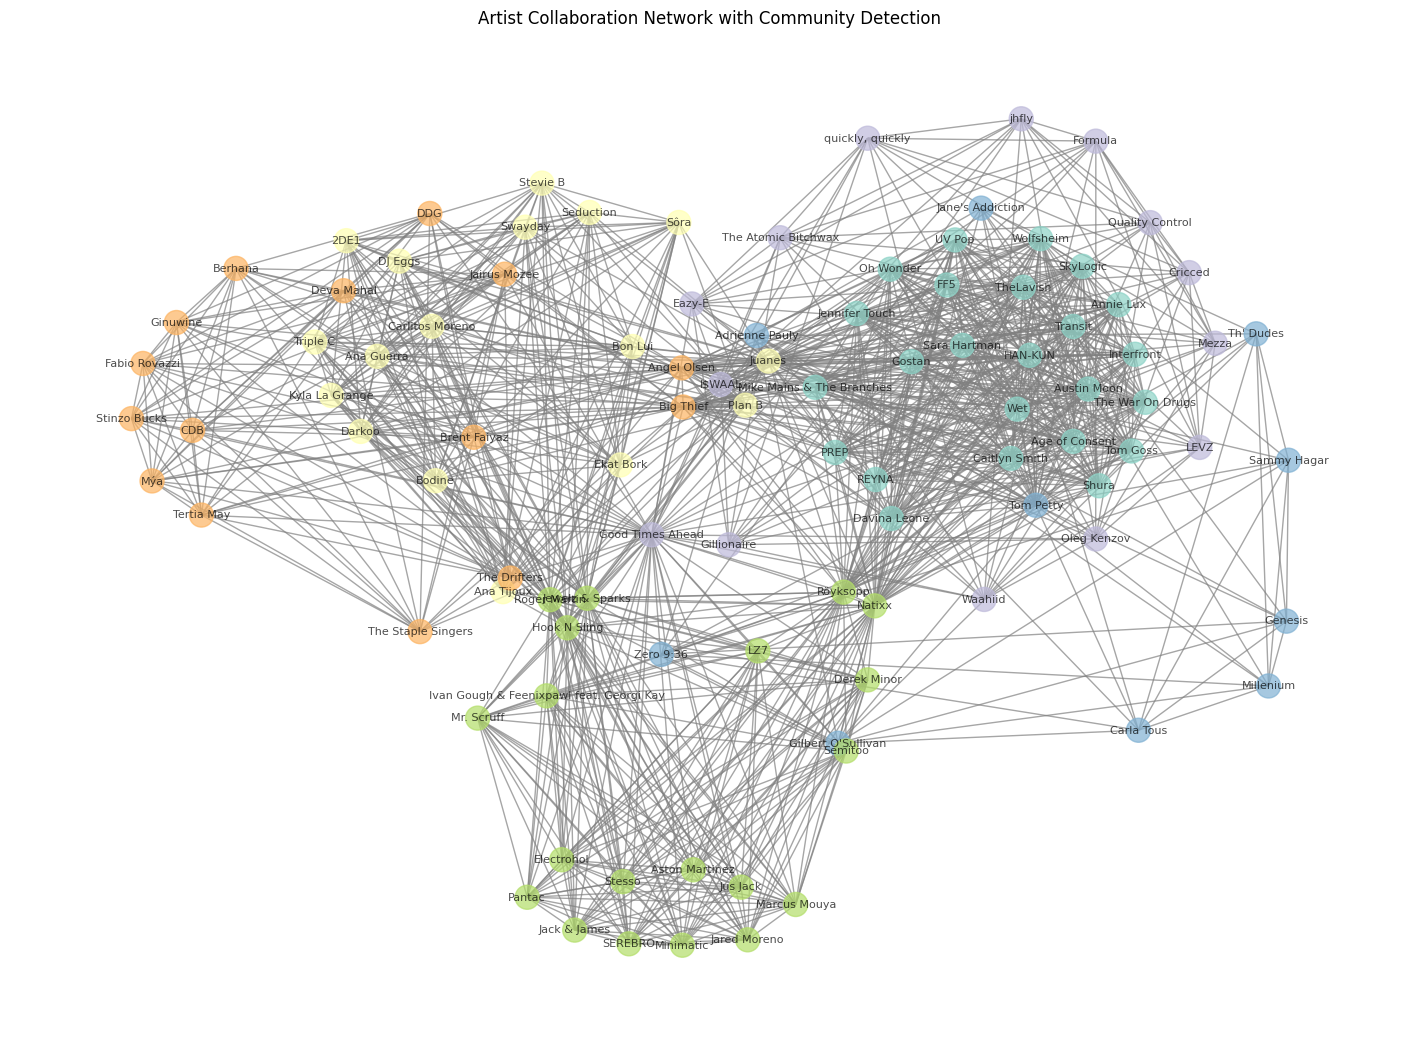


=== COMMUNITY ANALYSIS ===

Community 1 (1595 artists):
Artists: Kevitch, True Damage, TheLavish, Trove, Bleachers, Rachael Nemiroff, Oh Wonder, Passion, ÊMIA, The War On Drugs
Top genres: {'pop': 10}

Community 2 (1646 artists):
Artists: Man Parrish, Eddy Walker, UNOMAS, Zach Farache, Joseph El De La Urba, N'Klabe, Rapper School, Denine, Lead, Wolfine
Top genres: {'latin': 10}

Community 3 (2111 artists):
Artists: Bipo Montana, Nazar, Young Scooter, Jennifer Lopez, DJ KABOO, I$WAAL, Juju, The Pretty Reckless, Mystikal, Power Supply
Top genres: {'rap': 10, 'pop': 1, 'latin': 1}

Community 5 (1416 artists):
Artists: John Denver, Massface, Free, Jan Hammer, Thousand Foot Krutch, The Man Who, Status Quo, Bombus, Pomegranate Tiger, FMLYBND
Top genres: {'rock': 10, 'pop': 2}


In [12]:
### Adding Community Detection

# Louvain Algorithm
communities_louvain = nx_comm.louvain_communities(G_artists, seed = 1337)

# Create community mapping
community_map = {}
for i, community in enumerate(communities_louvain):
    for artist in community:
        community_map[artist] = i

# Plot network
largest_component = max(nx.connected_components(G_artists), key = len)
subgraph = G_artists.subgraph(list(largest_component)[:100])  # Take first 100 nodes

plt.figure(figsize = (14, 10))
pos = nx.spring_layout(subgraph, k = 1, iterations = 50) # Spring layout

# Color nodes by community
node_colors = []
cmap = plt.cm.Set3  # Use colormap
for node in subgraph.nodes():
    if node in community_map:
        node_colors.append(cmap(community_map[node] % 12))
    else:
        node_colors.append('lightgray')

nx.draw(subgraph, pos, node_size = 300, node_color = node_colors, 
        edge_color = 'gray', alpha = 0.7, with_labels = True, font_size = 8)
plt.title('Artist Collaboration Network with Community Detection')
plt.show()

# Communities by genre
print("\n=== COMMUNITY ANALYSIS ===")
for i, community in enumerate(communities_louvain[:5]):  # Get top 6 communities (number of genres)
    if len(community) >= 3:  # Only show communities with 3+ artists
        print(f"\nCommunity {i+1} ({len(community)} artists):")
        
        # Get genres for artists
        community_artists = list(community)[:10]  # Show first 10 artists
        community_genres = []
        for artist in community_artists:
            artist_data = spotify_df[spotify_df['track_artist'] == artist]
            genres = artist_data['playlist_genre'].unique()
            community_genres.extend(genres)
        
        # Count genre occurrences
        from collections import Counter
        genre_counts = Counter(community_genres)
        
        print(f"Artists: {', '.join(community_artists)}")
        print(f"Top genres: {dict(genre_counts.most_common(3))}")